# A Study of Transcription and Its Affects
---
**Contributors:** John M. Letey (John.Letey@colorado.edu), David A. Knox (David.Knox@colorado.edu)

**Notes:** To get to my GitHub repository, go to this [website](https://github.com/JohnLetey/A-Study-of-Transcription-and-Its-Affects). For instructions on how to use my repository, go [here](https://github.com/JohnLetey/A-Study-of-Transcription-and-Its-Affects/blob/master/instructions.md).

This project follows the below pipeline.

![pipeline](https://github.com/JohnLetey/A-Study-of-Transcription-and-Its-Affects/blob/master/pipeline.png?raw=true)

I have broken this project into to major portions. The first portion calculates the hits (weak and strong transcription factor binding sights) for a specified chromosome and transcription factor. The second portion analyses these hits. Let's talk about these two portions more in depth.

## Part 1: Finding the Hits
---
To calculate the hits, I read in from a file called $\texttt{input.txt}$ which is formatted as follows:

|  Line Number  | Description |
|:---:|:---:|
| 1 | Name of fasta file |
| 2 | Name of tamo file |
| 3 | Weak threshold value |
| 4 | Strong threshold value |
| 5 | Size of each category of distances between sites |
| 6 | Maximum allowed plus/minus distance between a strong and weak site |

I had originally sought out to do this project in [MATLAB](https://www.mathworks.com), but with the fact that we're running our code with super big data (and for the sake of your and my sanity), I have decided to use [Python](https://www.python.org), with [Jupyter Notebook](http://jupyter.org), for this project. I read in the chromosomes from a fasta file called $\texttt{SGDv3.fasta}$ and the associated PSSM to the transcription factor from the tamo file called $\texttt{yeast.tamo}$. Before we continue, let's first read in $\texttt{input.txt}$.

In [1]:
def readInInput(filename):
    # Open the file
    fileID = open(filename, 'r')
    # Initialize the list that will hold the input
    data = []
    # Read in the input file
    line = fileID.readline()
    while line:
        if line[len(line)-1] == '\n':
            data.append(line[:len(line)-1])
        else:
            data.append(line)
        line = fileID.readline()
    # Convert into correct units
    data[2] = float(data[2])
    data[3] = float(data[3])
    data[4] = int(data[4])
    data[5] = int(data[5])
    # Close the file
    fileID.close()
    # Return
    return data

# Test readInInput
Input = readInInput('Data/input.txt')
print(Input)

['Data/SGDv3.fasta', 'Data/yeast.tamo', 0.35, 0.7, 1, 150]


 Now that we've read in $\texttt{input.txt}$, let's implement a function that reads in from $\texttt{SGDv3.fasta}$ a specific chromosome.

In [2]:
def getCHR(filename, chrName):
    # Open the fasta file
    fileID = open(filename, 'r')
    # Define the dictionary that will the hold the data from the chromosomes
    chrData = {}
    # Read in the fasta file
    line = fileID.readline()
    while line:
        if line[0] == '>':
            title = line[1:len(line)-1]
            chrData[title] = ''
        else:
            chrData[title] += line[:len(line)-1]
        line = fileID.readline()
    # Return the specified chromosome
    if chrName == 'all':
        allCHRData = {}
        count = 0
        for i in chrData.keys():
            if count < len(chrData)-2:
                if int(i[3:]):
                    allCHRData[i] = chrData[i]
            count += 1
        return allCHRData
    else:
        return chrData[chrName]

After we read in the chromosomes, we also need to read in the corresponding PSSM to the given transcription factor.

In [3]:
def getPSSM(filename, TF):
    # Open the tamo file
    fileID = open(filename, 'r')
    # Read in the tamo file
    tamoData = []
    fileID = open(filename, 'r')
    line = fileID.readline()
    while line:
        tamoData.append(line[:len(line)-1])
        line = fileID.readline()
    # Define what we're looking for
    correctLine = 'Source:  ' + TF
    # Search for your correct line
    for i in range(123):
        # Get line 19 + 42*i
        line = tamoData[19 + 42*i - 1]
        # Compare
        if line == correctLine:
            position = i
    # Set the start line for the PSSM
    startLine = 2 + 42*position
    # Get the startLine's length to figure out the length of the PSSM
    firstLine = tamoData[startLine]
    lenOfPSSM = int((len(firstLine) - 3)/10) - 1
    # Create a list that will contain the PSSM
    PSSM = [[0 for i in range(lenOfPSSM)] for i in range(4)]
    # Get the all the lines of the PSSM
    firstLine = tamoData[startLine]
    secondLine = tamoData[startLine + 1]
    thirdLine = tamoData[startLine + 2]
    fourthLine = tamoData[startLine + 3]
    # Get the values and insert them into the PSSM
    for i in range(lenOfPSSM):
        value = firstLine[(i*10 + 6):(i*10 + 12)]
        PSSM[0][i] = float(value)
        value = secondLine[(i*10 + 6):(i*10 + 12)]
        PSSM[1][i] = float(value)
        value = thirdLine[(i*10 + 6):(i*10 + 12)]
        PSSM[2][i] = float(value)
        value = fourthLine[(i*10 + 6):(i*10 + 12)]
        PSSM[3][i] = float(value)
    # Return the PSSM and the length of the PSSM
    return PSSM, lenOfPSSM

After we read in both the chromosomes and the corresponding PSSM for the given transcription factor, we need to write a function that caluclates the output of the PSSM when you give it a specific string.

In [4]:
def outputOfPSSM(PSSM, sequence, maximum, lenOfPSSM):
    # Go through the PSSM and calculate the output for the given sequence
    output = 1.0
    for i in range(lenOfPSSM):
        if sequence[i] == 'A':
            output += PSSM[0][i]
        if sequence[i] == 'C':
            output += PSSM[1][i]
        if sequence[i] == 'T':
            output += PSSM[2][i]
        if sequence[i] == 'G':
            output += PSSM[3][i]
    output /= maximum
    # Return output
    return output

Now that we have all of these functions, let's use them to calculate the hits for the specified chromosome and transcription factor.

In [5]:
# Import the function that gets the time
from time import time

def calculateHits(chrFilename, CHR, PSSMFilename, TF, OutFilename):
    # Get the time at the begining of the function
    t_beg = time()
    # Get the chromosome
    chrData = getCHR(chrFilename, CHR)
    # Get the PSSM for the corresponding transcription factor
    PSSM, lenOfPSSM = getPSSM(PSSMFilename, TF)
    # Get the strong and weak thresholds
    weakThreshold = Input[2]
    strongThreshold = Input[3]
    # Open the output file
    fileID = open(OutFilename, 'w')
    # Write to the output file
    fileID.write('# searching ' + CHR + '\n')
    fileID.write('# for transcription factor ' + TF + '\n')
    fileID.write('# weak threshold: ' + str(weakThreshold) + '\n')
    fileID.write('# strong threshold: ' + str(strongThreshold) + '\n')
    fileID.write('\n')
    fileID.write('# The following is the outputs of the program in the forwards direction. \n')
    fileID.write('# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ \n')
    fileID.write('# \n')
    fileID.write('# position  strength  type       \n')
    # Find the maximum possible probability
    maximum = 1
    for i in range(lenOfPSSM):
        maxForCollumn = 0
        for j in range(4):
            if PSSM[j][i] > maxForCollumn:
                maxForCollumn = PSSM[j][i]
        maximum = maximum + maxForCollumn
    # Evaluate the chromosome with the PSSM and count how many strong and weak sites there are for the forwards direction
    out = []
    positionOfWeak = []
    positionOfStrong = []
    weakAmount = 0
    strongAmount = 0
    for i in range(len(chrData)):
        if (i + lenOfPSSM) > len(chrData):
            output = outputOfPSSM(PSSM, chrData[i:] + str([' ' for i in range(i + lenOfPSSM - 1 - len(chrData))]), maximum, lenOfPSSM)
        else:
            output = outputOfPSSM(PSSM, chrData[i:(i + lenOfPSSM)], maximum, lenOfPSSM)
        out.append(output)
        if output >= weakThreshold:
            if output < strongThreshold:
                fileID.write('  ' + str(i) + '     ' + str(output) + '     ' + ' ' + 'weak  ' + '\n')
                weakAmount += 1
                positionOfWeak.append(i)
            else:
                fileID.write('  ' + str(i) + '     ' + str(output) + '     ' + ' ' + 'strong  ' + '\n')
                strongAmount += 1
                positionOfStrong.append(i)
    # Output to the output file the amount of weak and strong sites for the forwards direction
    fileID.write('# \n')
    fileID.write('# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ \n')
    fileID.write('# \n')
    fileID.write('# The number of weak sites for the forwards direction is ' + str(weakAmount) + '\n')
    fileID.write('# The number of strong sites for the forwards direction is ' + str(strongAmount) + '\n')
    # Write to the output file
    fileID.write('\n')
    fileID.write('\n')
    fileID.write('# The following is the outputs of the program in the reverse compliment direction. \n')
    fileID.write('# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ \n')
    fileID.write('# \n')
    fileID.write('# position  strength  type       \n')
    # Take the reverse compliment of the PSSM
    for i in range(4):
        PSSM[i] = PSSM[i][::-1]
    temp = PSSM[0]
    PSSM[0] = PSSM[3]
    PSSM[3] = temp
    temp = PSSM[1]
    PSSM[1] = PSSM[2]
    PSSM[2] = temp
    # Find the maximum possible probability
    maximum = 1
    for i in range(lenOfPSSM):
        maxForCollumn = 0
        for j in range(4):
            if PSSM[j][i] > maxForCollumn:
                maxForCollumn = PSSM[j][i]
        maximum = maximum + maxForCollumn
    # Evaluate the chromosome with the PSSM and count how many strong and weak sites there are for the reverse compliment direction
    out = []
    positionOfWeak = []
    positionOfStrong = []
    weakAmount = 0
    strongAmount = 0
    for i in range(len(chrData)):
        if (i + lenOfPSSM) > len(chrData):
            output = outputOfPSSM(PSSM, chrData[i:] + str([' ' for i in range(i + lenOfPSSM - 1 - len(chrData))]), maximum, lenOfPSSM)
        else:
            output = outputOfPSSM(PSSM, chrData[i:(i + lenOfPSSM)], maximum, lenOfPSSM)
        out.append(output)
        if output >= weakThreshold:
            if output < strongThreshold:
                fileID.write('  ' + str(i) + '     ' + str(output) + '     ' + ' ' + 'weak  ' + '\n')
                weakAmount += 1
                positionOfWeak.append(i)
            else:
                fileID.write('  ' + str(i) + '     ' + str(output) + '     ' + ' ' + 'strong  ' + '\n')
                strongAmount += 1
                positionOfStrong.append(i)
    # Output to the output file the amount of weak and strong sites for the reverse compliment direction
    fileID.write('# \n')
    fileID.write('# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ \n')
    fileID.write('# \n')
    fileID.write('# The number of weak sites for the reverse compliment direction is ' + str(weakAmount) + '\n')
    fileID.write('# The number of strong sites for the reverse compliment direction is ' + str(strongAmount) + '\n')
    # Close the output file
    fileID.close()
    # Get the time at the end of the function
    t_end = time()
    # Return the amount of seconds it took the function to run (in seconds)
    return t_end - t_beg

#calculateHits('SGDv3.fasta', 'all', 'yeast.tamo', 'YAP5', 'hits.txt')

## Part 2: Analysing the Hits
---
Now that we have calculated the hits, this wouldn't be a research project without analysing those hits.

In [ ]:
# Import the function that gets the time
from time import time
# Import matplotlib
import matplotlib.pyplot as plt
# Import the mean function
from statistics import mean
# Import the standard deviation function
from numpy import std

def hist(InFilename, HitsInFilename, PicFile):
    # Get the time at the begining of the function
    t_beg = time()
    # Open the input file that holds the hits
    fileID = open(HitsInFilename, 'r')
    # Initialize the list that will hold the input
    data = []
    # Read in the input file
    line = fileID.readline()
    while line:
        data.append(line[:len(line)-1])
        line = fileID.readline()
    # Parse the input
    weakSites = []
    strongSites = []
    for i in range(len(data)):
        line = data[i]
        if len(line) != 0:
            if line[0] != '#':
                # Get the position of the hit
                position = line[2:8]
                position = int(position)
                # Get the type of the hit
                typeOfHit = line[len(line)-8:len(line)-2]
                # Input the position into the correct list
                if typeOfHit == 'strong':
                    strongSites.append(position)
                if typeOfHit == '  weak':
                    weakSites.append(position)
    # Sort the lists holding the hits
    weakSites = list(set(weakSites))
    weakSites.sort()
    strongSites = list(set(strongSites))
    strongSites.sort()
    # Close the input file that holds the hits
    fileID.close()
    # Read in the input file
    Input = readInInput(InFilename)
    # Get the number of plus or minus range of what we're going to be anaylsing and the size of the buckets
    r = Input[5]
    s = Input[4]
    # Analyse the hits
    categories = [0 for i in range(r)]
    #for i in range(len(strongSites)):
    #    for j in range(len(weakSites)):
    #        value = abs(strongSites[i] - weakSites[j])
    #        for k in range(r//s):
    #            if (value <= (s*k) and (value > s*(k-1))):
    #                categories[k] += 1
    for i in range(len(strongSites)):
        position1 = 0
        position2 = 0
        for j in range(len(weakSites)):
            if weakSites[j] <= strongSites[i]-r:
                position1 = j
            if weakSites[j] <= strongSites[i]+r:
                position2 = j
        for j in range(position1, position2):
            value = abs(strongSites[i] - weakSites[j])
            for k in range(r//s):
                if (value <= (s*k) and (value > s*(k-1))):
                    categories[k] += 1
    # Plot the histogram
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    ax.bar(range(len(categories)), categories, color='black', label='Histogram')
    plt.plot(range(len(categories)), [mean(categories) for i in range(len(categories))], color='red', label='Mean')
    plt.plot(range(len(categories)), [2*std(categories)+mean(categories) for i in range(len(categories))], color='steelblue', label='Standard Deviation (+2)')
    plt.plot(range(len(categories)), [std(categories)+mean(categories) for i in range(len(categories))], color='cyan', label='Standard Deviation (+1)')
    if mean(categories)-std(categories) >= 0:
        plt.plot(range(len(categories)), [mean(categories)-std(categories) for i in range(len(categories))], color='cyan', label='Standard Deviation (-1)')
    if mean(categories)-2*std(categories) >= 0:
        plt.plot(range(len(categories)), [mean(categories)-2*std(categories) for i in range(len(categories))], color='steelblue', label='Standard Deviation (-2)')
    ax.legend()
    fig.savefig(PicFile)
    plt.show()
    # Get the time at the end of the function
    t_end = time()
    # Return the amount of seconds it took the function to run (in seconds)
    return t_end - t_beg

Now that we have 

Transcription Factor: HSF1


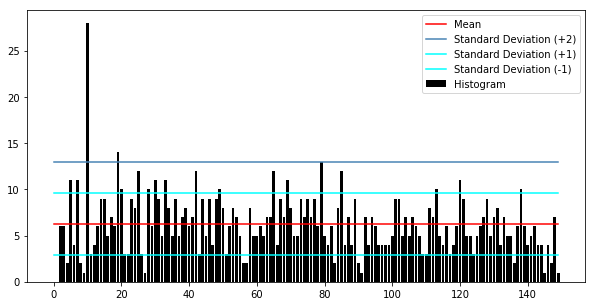

Transcription Factor: RPN4


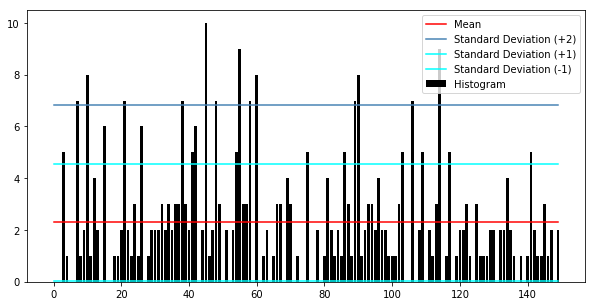

Transcription Factor: THI2


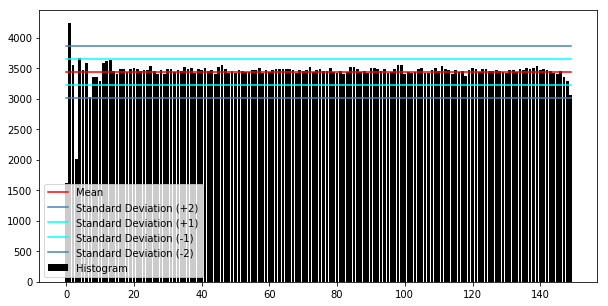

Transcription Factor: UGA3


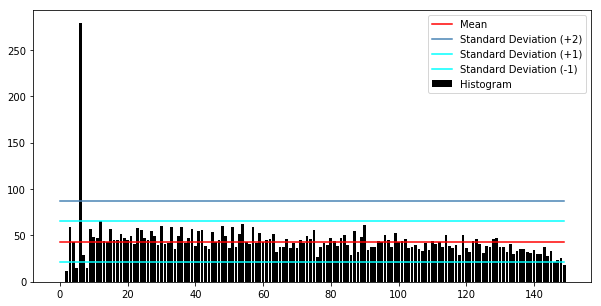

Transcription Factor: SMP1


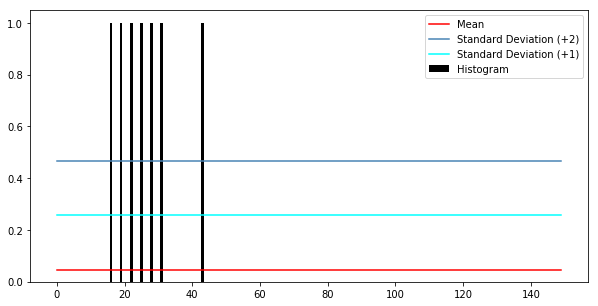

Transcription Factor: RTG3


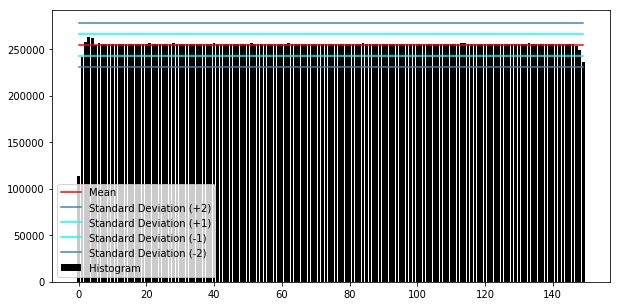

Transcription Factor: CIN5


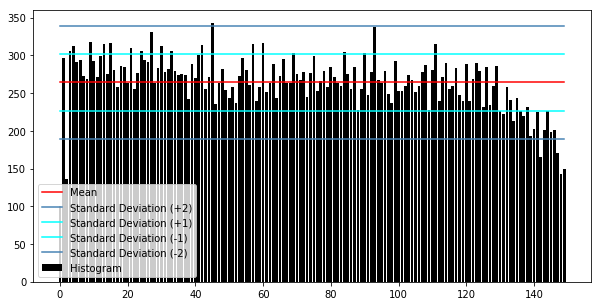

Transcription Factor: DAL82


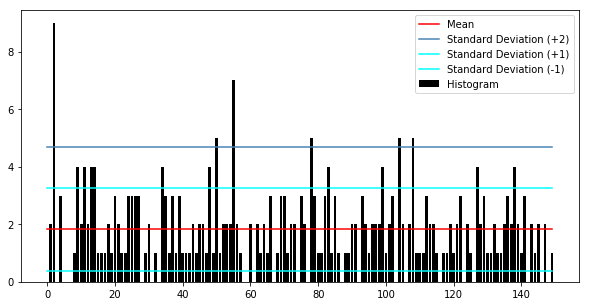

Transcription Factor: DAL80


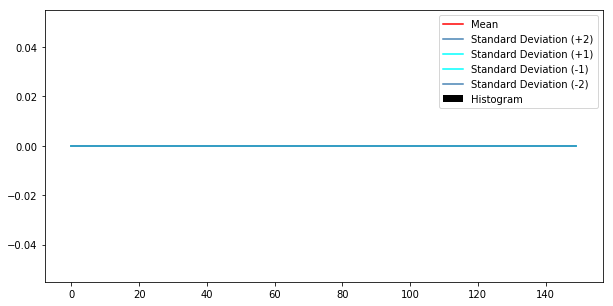

Transcription Factor: DAL81


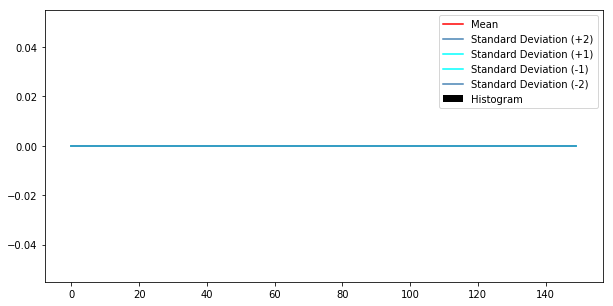

Transcription Factor: REB1


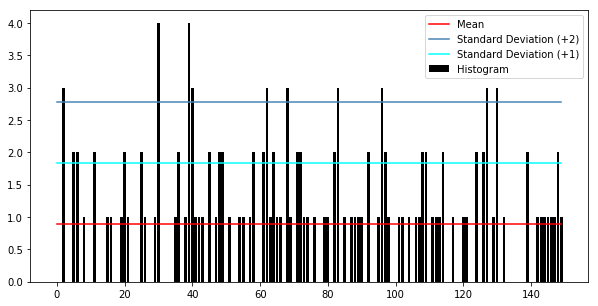

Transcription Factor: PUT3


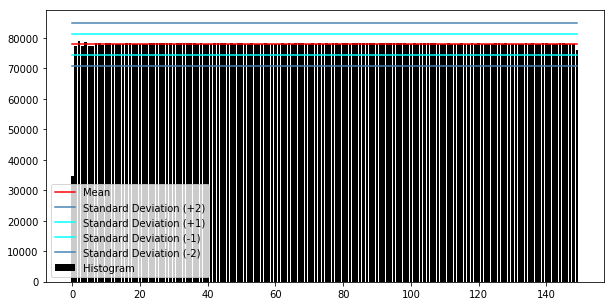

Transcription Factor: BAS1


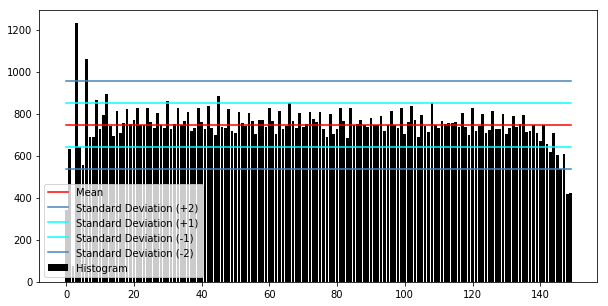

Transcription Factor: YAP3


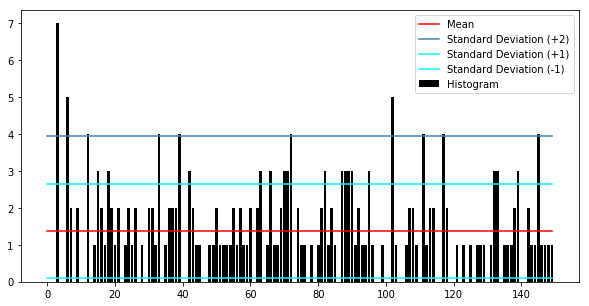

Transcription Factor: SIP4


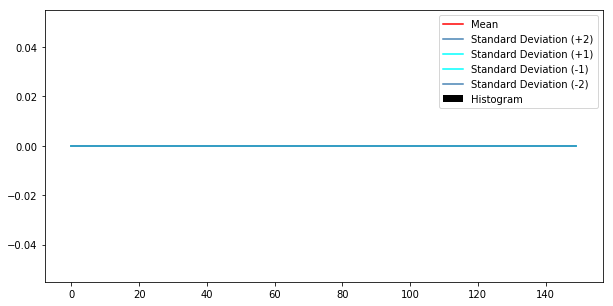

Transcription Factor: SOK2


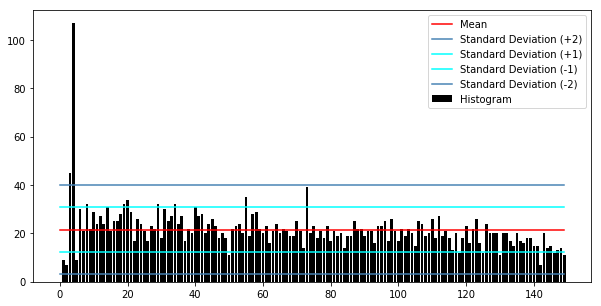

Transcription Factor: NDD1


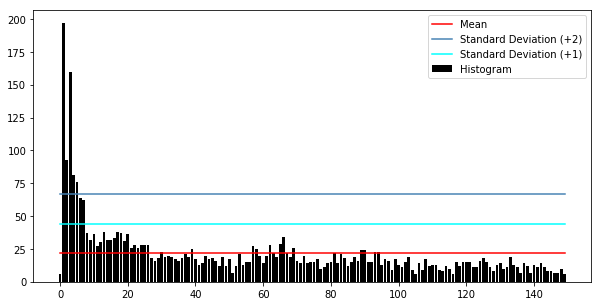

Transcription Factor: FKH1


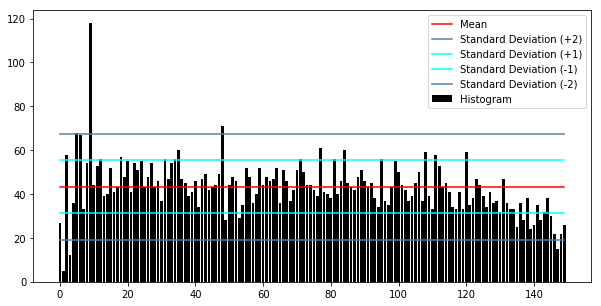

Transcription Factor: SKO1


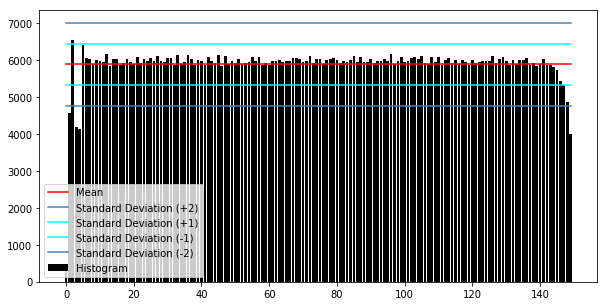

Transcription Factor: FKH2


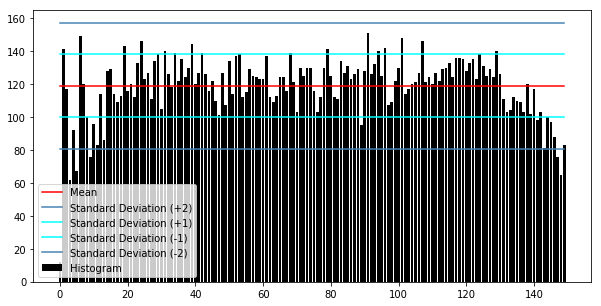

Transcription Factor: CBF1


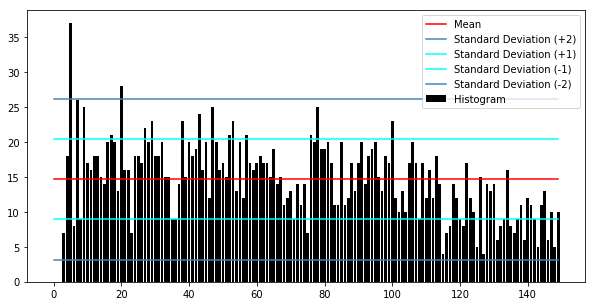

Transcription Factor: GCR1


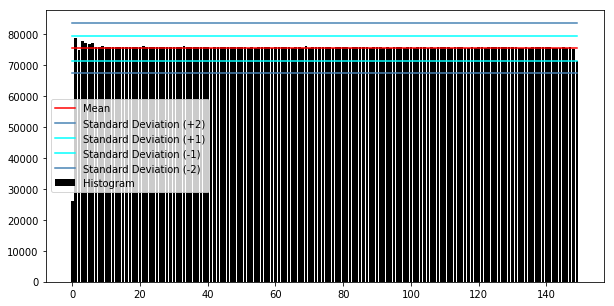

Transcription Factor: GCR2


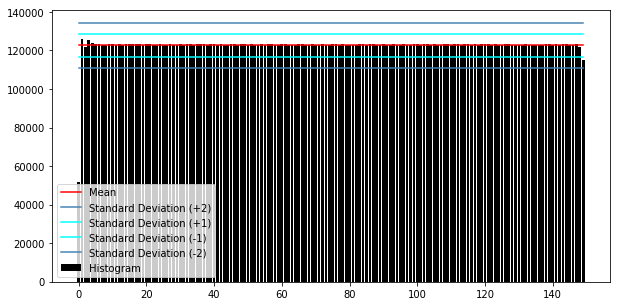

Transcription Factor: YOX1


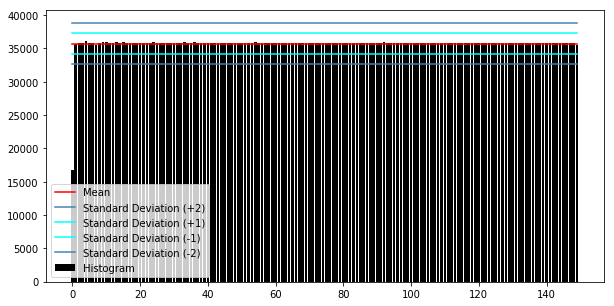

Transcription Factor: HAP1


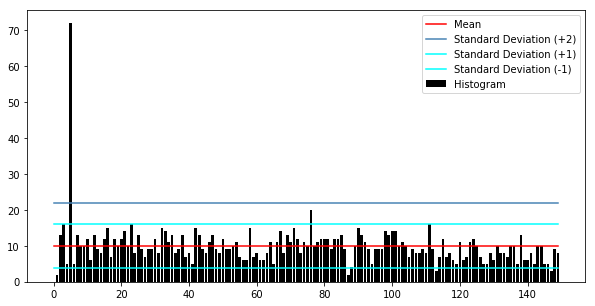

Transcription Factor: OPI1


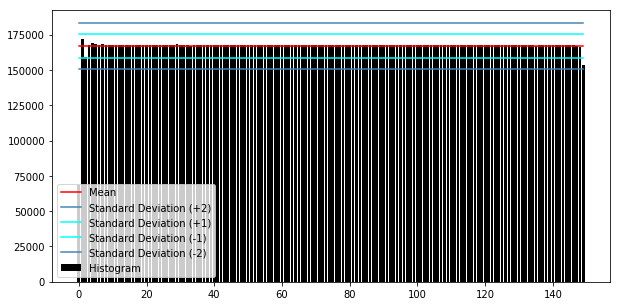

Transcription Factor: CRZ1


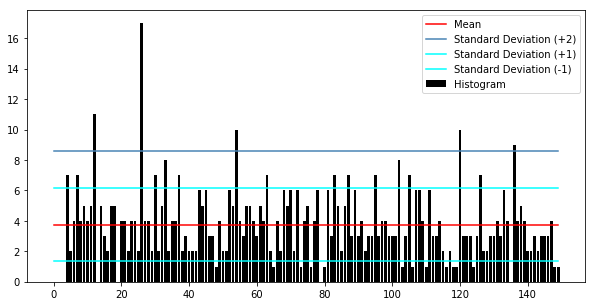

Transcription Factor: ABF1


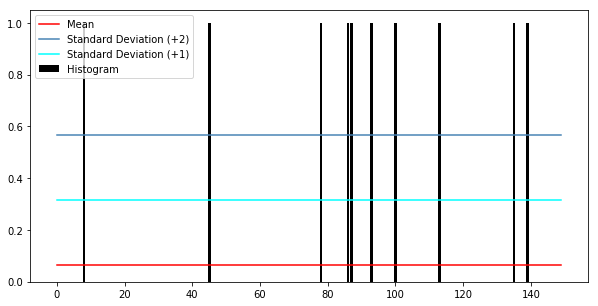

Transcription Factor: YDR026C


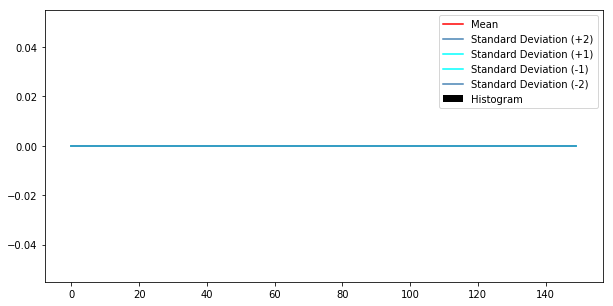

Transcription Factor: SUT1


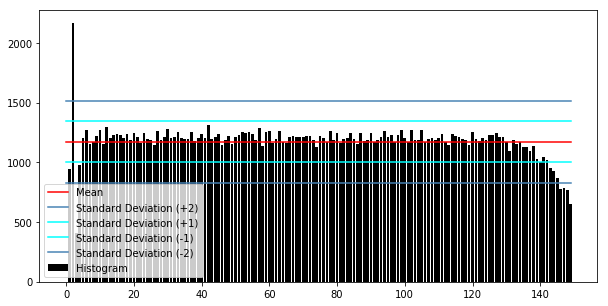

Transcription Factor: AFT2


In [ ]:
# Import the function that gets the time
from time import time

def main(InFilename):
    # Get the time at the begining of the function
    t_beg = time()
    
    Input = readInInput(InFilename)
    fileID = open(Input[1])
    line = fileID.readline()
    while line:
        if line[:6] == 'Source':
            print('Transcription Factor:', line[9:len(line)-1])
            time_est = calculateHits(Input[0], 'chr1', Input[1], line[9:len(line)-1], 'Hits/hits' + line[9:len(line)-1] + '.txt')
            time_est = hist(InFilename, 'Hits/hits' + line[9:len(line)-1] + '.txt', 'Histograms/histogram' + line[9:len(line)-1] + '.png')
        line = fileID.readline()
    fileID.close()
    
    # Get the time at the end of the function
    t_end = time()
    # Return the amount of seconds it took the function to run (in seconds)
    return t_end - t_beg
    
main('Data/input.txt')

In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

def func(chrFilename, chromosome):
    chrData = getCHR(filename, 'all')
    if chromosome == 'all':
        print('You have selected all of the chromosomes.')
    else:
        print('You have selected chromosome', chromosome[len(chromosome)-1:], '(', chromosome, ')')
    return
Chromosome = []
for i in chrData.keys():
    Chromosome.append(i)
Chromosome.append('all')
answer = interact(func, chrFilename='', chromosome=Chromosome);

In [ ]:
chromosome=[x for x in chrData.keys()]
chromosome.append
print(chromosome)